In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import timm
import sys 
from torchinfo import summary
from scipy import signal
import pyVHR as vhr
import pickle
from typing import Optional
 



In [12]:
PATCH_SIZE = 16
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * 3
NUM_PATCHES = 100
IMG_SIZE = PATCH_SIZE * NUM_PATCHES
HEADS = 12
BLOCKS = 12
BATCH = 300
LENGTH = 160

In [3]:
"""
Adapted from https://github.com/lukemelas/simple-bert
"""
import math

import pdb

'''
Temporal Center-difference based Convolutional layer (3D version)
theta: control the percentage of original convolution and centeral-difference convolution
'''
class CDC_T(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1, bias=False, theta=0.6):

        super(CDC_T, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)
        self.theta = theta

    def forward(self, x):
        out_normal = self.conv(x)

        if math.fabs(self.theta - 0.0) < 1e-8:
            return out_normal
        else:
            # pdb.set_trace()
            [C_out, C_in, t, kernel_size, kernel_size] = self.conv.weight.shape

            # only CD works on temporal kernel size>1
            if self.conv.weight.shape[2] > 1:
                kernel_diff = self.conv.weight[:, :, 0, :, :].sum(2).sum(2) + self.conv.weight[:, :, 2, :, :].sum(
                    2).sum(2)
                kernel_diff = kernel_diff[:, :, None, None, None]
                out_diff = F.conv3d(input=x, weight=kernel_diff, bias=self.conv.bias, stride=self.conv.stride,
                                    padding=0, dilation=self.conv.dilation, groups=self.conv.groups)
                return out_normal - self.theta * out_diff

            else:
                return out_normal




def split_last(x, shape):
    "split the last dimension to given shape"
    shape = list(shape)
    assert shape.count(-1) <= 1
    if -1 in shape:
        shape[shape.index(-1)] = int(x.size(-1) / -np.prod(shape))
    return x.view(*x.size()[:-1], *shape)


def merge_last(x, n_dims):
    "merge the last n_dims to a dimension"
    s = x.size()
    assert n_dims > 1 and n_dims < len(s)
    return x.view(*s[:-n_dims], -1)



class MultiHeadedSelfAttention_TDC_gra_sharp(nn.Module):
    """Multi-Headed Dot Product Attention with depth-wise Conv3d"""
    def __init__(self, dim, num_heads, dropout, theta):
        super().__init__()
        
        self.proj_q = nn.Sequential(
            CDC_T(dim, dim, 3, stride=1, padding=1, groups=1, bias=False, theta=theta),  
            nn.BatchNorm3d(dim),
            #nn.ELU(),
        )
        self.proj_k = nn.Sequential(
            CDC_T(dim, dim, 3, stride=1, padding=1, groups=1, bias=False, theta=theta),  
            nn.BatchNorm3d(dim),
            #nn.ELU(),
        )
        self.proj_v = nn.Sequential(
            nn.Conv3d(dim, dim, 1, stride=1, padding=0, groups=1, bias=False),  
            #nn.BatchNorm3d(dim),
            #nn.ELU(),
        )
        
        #self.proj_q = nn.Linear(dim, dim)
        #self.proj_k = nn.Linear(dim, dim)
        #self.proj_v = nn.Linear(dim, dim)
        
        self.drop = nn.Dropout(dropout)
        self.n_heads = num_heads
        self.scores = None # for visualization

    def forward(self, x, gra_sharp):    # [B, 4*4*40, 128]
        """
        x, q(query), k(key), v(value) : (B(batch_size), S(seq_len), D(dim))
        mask : (B(batch_size) x S(seq_len))
        * split D(dim) into (H(n_heads), W(width of head)) ; D = H * W
        """
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        
        [B, P, C]=x.shape
        x = x.transpose(1, 2).view(B, C, P//8, 4, 2)      # [B, dim, 40, 4, 4]
        q, k, v = self.proj_q(x), self.proj_k(x), self.proj_v(x)
        q = q.flatten(2).transpose(1, 2)  # [B, 4*4*40, dim]
        k = k.flatten(2).transpose(1, 2)  # [B, 4*4*40, dim]
        v = v.flatten(2).transpose(1, 2)  # [B, 4*4*40, dim]
        
        q, k, v = (split_last(x, (self.n_heads, -1)).transpose(1, 2) for x in [q, k, v])
        # (B, H, S, W) @ (B, H, W, S) -> (B, H, S, S) -softmax-> (B, H, S, S)
        scores = q @ k.transpose(-2, -1) / gra_sharp

        scores = self.drop(F.softmax(scores, dim=-1))
        # (B, H, S, S) @ (B, H, S, W) -> (B, H, S, W) -trans-> (B, S, H, W)
        h = (scores @ v).transpose(1, 2).contiguous()
        # -merge-> (B, S, D)
        h = merge_last(h, 2)
        self.scores = scores
        return h, scores




class PositionWiseFeedForward_ST(nn.Module):
    """FeedForward Neural Networks for each position"""
    def __init__(self, dim, ff_dim):
        super().__init__()
        
        self.fc1 = nn.Sequential(
            nn.Conv3d(dim, ff_dim, 1, stride=1, padding=0, bias=False),  
            nn.BatchNorm3d(ff_dim),
            nn.ELU(),
        )
        
        self.STConv = nn.Sequential(
            nn.Conv3d(ff_dim, ff_dim, 3, stride=1, padding=1, groups=ff_dim, bias=False),  
            nn.BatchNorm3d(ff_dim),
            nn.ELU(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Conv3d(ff_dim, dim, 1, stride=1, padding=0, bias=False),  
            nn.BatchNorm3d(dim),
        )

    def forward(self, x):    # [B, 4*4*40, 128]
        [B, P, C]=x.shape
        #x = x.transpose(1, 2).view(B, C, 40, 4, 4)      # [B, dim, 40, 4, 4]
        x = x.transpose(1, 2).view(B, C, P//8, 4, 2)      # [B, dim, 40, 4, 4]
        x = self.fc1(x)		              # x [B, ff_dim, 40, 4, 4]
        x = self.STConv(x)		          # x [B, ff_dim, 40, 4, 4]
        x = self.fc2(x)		              # x [B, dim, 40, 4, 4]
        x = x.flatten(2).transpose(1, 2)  # [B, 4*4*40, dim]
        
        return x
        
        # (B, S, D) -> (B, S, D_ff) -> (B, S, D)
        #return self.fc2(F.gelu(self.fc1(x)))





class Block_ST_TDC_gra_sharp(nn.Module):
    """Transformer Block"""
    def __init__(self, dim, num_heads, ff_dim, dropout, theta):
        super().__init__()
        self.attn = MultiHeadedSelfAttention_TDC_gra_sharp(dim, num_heads, dropout, theta)
        self.proj = nn.Linear(dim, dim)
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.pwff = PositionWiseFeedForward_ST(dim, ff_dim)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, gra_sharp):
        Atten, Score = self.attn(self.norm1(x), gra_sharp)
        h = self.drop(self.proj(Atten))
        x = x + h
        h = self.drop(self.pwff(self.norm2(x)))
        x = x + h
        return x, Score


class Transformer_ST_TDC_gra_sharp(nn.Module):
    """Transformer with Self-Attentive Blocks"""
    def __init__(self, num_layers, dim, num_heads, ff_dim, dropout, theta):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block_ST_TDC_gra_sharp(dim, num_heads, ff_dim, dropout, theta) for _ in range(num_layers)])

    def forward(self, x, gra_sharp):
        for block in self.blocks:
            x, Score = block(x, gra_sharp)
        return x, Score

In [34]:
"""model.py - Model and module class for ViT.
   They are built to mirror those in the official Jax implementation.
"""

'''from typing import Optional
import torch
from torch import nn
from torch.nn import functional as F
import math

from .transformer_layer import Transformer_ST_TDC_gra_sharp

import pdb'''


def as_tuple(x):
    return x if isinstance(x, tuple) else (x, x)

'''
Temporal Center-difference based Convolutional layer (3D version)
theta: control the percentage of original convolution and centeral-difference convolution
'''
class CDC_T(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1, bias=False, theta=0.6):

        super(CDC_T, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)
        self.theta = theta

    def forward(self, x):
        out_normal = self.conv(x)

        if math.fabs(self.theta - 0.0) < 1e-8:
            return out_normal
        else:
            # pdb.set_trace()
            [C_out, C_in, t, kernel_size, kernel_size] = self.conv.weight.shape

            # only CD works on temporal kernel size>1
            if self.conv.weight.shape[2] > 1:
                kernel_diff = self.conv.weight[:, :, 0, :, :].sum(2).sum(2) + self.conv.weight[:, :, 2, :, :].sum(
                    2).sum(2)
                kernel_diff = kernel_diff[:, :, None, None, None]
                out_diff = F.conv3d(input=x, weight=kernel_diff, bias=self.conv.bias, stride=self.conv.stride,
                                    padding=0, dilation=self.conv.dilation, groups=self.conv.groups)
                return out_normal - self.theta * out_diff

            else:
                return out_normal




# stem_3DCNN + ST-ViT with local Depthwise Spatio-Temporal MLP
class ViT_ST_ST_Compact3_TDC_gra_sharp(nn.Module):

    def __init__(
        self, 
        name: Optional[str] = None, 
        pretrained: bool = False, 
        patches: int = 16,
        dim: int = 768,
        ff_dim: int = 3072,
        num_heads: int = 12,
        num_layers: int = 12,
        attention_dropout_rate: float = 0.0,
        dropout_rate: float = 0.2,
        representation_size: Optional[int] = None,
        load_repr_layer: bool = False,
        classifier: str = 'token',
        #positional_embedding: str = '1d',
        in_channels: int = 3, 
        frame: int = 160,
        theta: float = 0.2,
        image_size: Optional[int] = None,
    ):
        super().__init__()

        
        self.image_size = image_size  
        self.frame = frame  
        self.dim = dim              

        # Image and patch sizes
        t, h, w = as_tuple(image_size)  # tube sizes
        ft, fh, fw = as_tuple(patches)  # patch sizes, ft = 4 ==> 160/4=40
        gt, gh, gw = t//ft, h // fh, w // fw  # number of patches
        seq_len = gh * gw * gt

        # Patch embedding    [4x16x16]conv
        self.patch_embedding = nn.Conv3d(dim, dim, kernel_size=(ft, fh, fw), stride=(ft, fh, fw))
        
        # Transformer
        self.transformer1 = Transformer_ST_TDC_gra_sharp(num_layers=num_layers//3, dim=dim, num_heads=num_heads, 
                                       ff_dim=ff_dim, dropout=dropout_rate, theta=theta)
        # Transformer
        self.transformer2 = Transformer_ST_TDC_gra_sharp(num_layers=num_layers//3, dim=dim, num_heads=num_heads, 
                                       ff_dim=ff_dim, dropout=dropout_rate, theta=theta)
        # Transformer
        self.transformer3 = Transformer_ST_TDC_gra_sharp(num_layers=num_layers//3, dim=dim, num_heads=num_heads, 
                                       ff_dim=ff_dim, dropout=dropout_rate, theta=theta)
        
        
        
        self.Stem0 = nn.Sequential(
            nn.Conv3d(3, dim//4, [1, 5, 5], stride=1, padding=[0,2,2]),
            nn.BatchNorm3d(dim//4),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2)),
        )
        
        self.Stem1 = nn.Sequential(
            nn.Conv3d(dim//4, dim//2, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(dim//2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2)),
        )
        self.Stem2 = nn.Sequential(
            nn.Conv3d(dim//2, dim, [3, 3, 3], stride=1, padding=1),
            nn.BatchNorm3d(dim),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2)),
        )
        
        #self.normLast = nn.LayerNorm(dim, eps=1e-6)
        
        
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=(8,1,1)),
            nn.Conv3d(dim, dim, [3, 1, 1], stride=1, padding=(1,0,0)),   
            nn.BatchNorm3d(dim),
            nn.ELU(),
        )
        self.upsample2 = nn.Sequential(
            nn.Upsample(scale_factor=(5,1,1)),
            nn.Conv3d(dim, dim//2, [3, 1, 1], stride=1, padding=(1,0,0)),   
            nn.BatchNorm3d(dim//2),
            nn.ELU(),
        )
 
        self.ConvBlockLast = nn.Conv1d(dim//2, 1, 1,stride=1, padding=0)
        
        
        # Initialize weights
        self.init_weights()
        
    @torch.no_grad()
    def init_weights(self):
        def _init(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # _trunc_normal(m.weight, std=0.02)  # from .initialization import _trunc_normal
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)  # nn.init.constant(m.bias, 0)
        self.apply(_init)


    def forward(self, x, gra_sharp):
        b, c, t, fh, fw = x.shape
        
        x = self.Stem0(x)
        x = self.Stem1(x)
        x = self.Stem2(x)  # [B, 64, 160, 64, 64]
        x = self.patch_embedding(x)  # [B, 64, 40, 4, 4]
        x = x.flatten(2).transpose(1, 2)  # [B, 40*4*4, 64]
        
        Trans_features, Score1 =  self.transformer1(x, gra_sharp)  # [B, 4*4*40, 64]
        Trans_features2, Score2 =  self.transformer2(Trans_features, gra_sharp)  # [B, 4*4*40, 64]
        Trans_features3, Score3 =  self.transformer3(Trans_features2, gra_sharp)  # [B, 4*4*40, 64]
        
        
        #Trans_features3 = self.normLast(Trans_features3)
        
        # upsampling heads
        #features_last = Trans_features3.transpose(1, 2).view(b, self.dim, 40, 4, 4) # [B, 64, 40, 4, 4]
        features_last = Trans_features3.transpose(1, 2).view(b, self.dim, 4, 5,2) # [B, 64, 40, 4, 4]
        
        features_last = self.upsample(features_last)		    # x [B, 64, 7*7, 80]
        features_last = self.upsample2(features_last)		    # x [B, 32, 7*7, 160]

        features_last = torch.mean(features_last,3)     # x [B, 32, 160, 4]  
        features_last = torch.mean(features_last,3)     # x [B, 32, 160]    
        rPPG = self.ConvBlockLast(features_last)    # x [B, 1, 160]
        
        #pdb.set_trace()
        
        rPPG = rPPG.squeeze(1)
        
        #return rPPG, Score1, Score2, Score3
        return rPPG


In [5]:
vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'
    
#SET DATASET

dataset_name = 'pure'           
video_DIR = '/var/datasets/VHR1/'  
BVP_DIR = '/var/datasets/VHR1/'    

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames


wsize = 8          
video_idx = 0      
fname = dataset.getSigFilename(video_idx)
sigGT = dataset.readSigfile(fname)
#train_bvp = [sigGT.data[0][i] for i in range(0,len(sigGT.data[0])-1,2)]
#bpmGT, timesGT = sigGT.getBPM(wsize)
videoFileName = dataset.getVideoFilename(video_idx)
print('Video processed name: ', videoFileName)
fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)

#vhr.plot.display_video(videoFileName)

/var/datasets/VHR1/PURE
Video processed name:  /var/datasets/VHR1/PURE/06-05/06-05.avi
Video frame rate:      30.0


In [6]:
#SKIN EXTRACTION AND VISUALIZATION
def patches_extraction():
    sig_extractor = vhr.extraction.SignalProcessing()
    sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull())
    seconds = 0
    sig_extractor.set_total_frames(seconds*fps)

    vhr.extraction.SkinProcessingParams.RGB_LOW_TH = 2
    vhr.extraction.SkinProcessingParams.RGB_HIGH_TH = 254
    vhr.extraction.SignalProcessingParams.RGB_LOW_TH = 2
    vhr.extraction.SignalProcessingParams.RGB_HIGH_TH = 254

    sig_extractor.set_visualize_skin_and_landmarks(
          visualize_skin=True, 
          visualize_landmarks=True, 
          visualize_landmarks_number=True, 
          visualize_patch=True)

    landmarks = [2, 3, 4, 5, 6, 8, 9, 10, 18, 21, 32, 35, 36, 43, 46, 47, 48, 50, 54, \
             58, 67, 68, 69, 71, 92, 93, 101, 103, 104, 108, 109, 116, 117, \
             118, 123, 132, 134, 135, 138, 139, 142, 148, 149, 150, 151, 152, 182, 187, 188, 193, 197, 201, 205, 206, 207, \
             210, 211, 212, 216, 234, 248, 251, 262, 265, 266, 273, 277, 278, 280, \
             284, 288, 297, 299, 322, 323, 330, 332, 333, 337, 338, 345, \
             346, 361, 363, 364, 367, 368, 371, 377, 379, 411, 412, 417, 421, 425, 426, 427, 430, 432, 436]

    print('Num landmarks: ', len(landmarks))
    #vhr.plot.visualize_landmarks_list(landmarks_list=landmarks)
    sig_extractor.set_landmarks(landmarks)

    #PATCHES EXTRACTION

    sig_extractor.set_square_patches_side(PATCH_SIZE + 0.0)
    patch_sig = sig_extractor.extract_patches(videoFileName, "squares", "mean")
    print('Size: (#frames, #landmarks, #channels) = ', patch_sig.shape)

    visualize_patches_coll = sig_extractor.get_visualize_patches()
    print('Number of frames processed: ',len(visualize_patches_coll))
    #vhr.plot.interactive_image_plot(visualize_patches_coll,1.0)

    patches = sig_extractor.patches
    print("patches: ", len(patches), len(patches[0]))
    #return torch.as_tensor(patches)
    return patches

patches = patches_extraction()


Num landmarks:  100


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Size: (#frames, #landmarks, #channels) =  (1959, 100, 3)
Number of frames processed:  1959
patches:  1959 100


torch.Size([1959, 160, 160, 3])


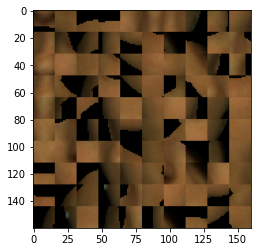

In [7]:
train_bvp = signal.resample(sigGT.data[0], len(patches)).astype(int)

#patches = patches[:len(test_bvp)+1]

#for each frame concatenate patches in one image
webs = []

for f_p in patches:
    tmp=np.concatenate(f_p[0:10])
    for i in range(10,len(f_p),10):
        r=np.concatenate(f_p[i:i+10])
        tmp=np.concatenate((tmp,r),axis=1)
    if webs==[]:
        webs = torch.unsqueeze(torch.as_tensor(tmp),0)
    else:
        webs=torch.cat((webs,torch.unsqueeze(torch.as_tensor(tmp),0)))

#inputs = torch.as_tensor(inputs)
print(webs.shape)

plt.imshow(webs[0])
plt.show()

In [8]:
with open(str(video_idx)+'-WEBS-'+str(PATCH_SIZE), 'wb') as f:
    pickle.dump((webs,train_bvp), f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open(str(video_idx)+'-WEBS-'+str(PATCH_SIZE), 'rb') as f:
    (webs,train_bvp) = pickle.load(f)    

In [18]:
def chunks(lst,bvp, n):
    tmp = []
    tmp_bvp = []
    for i in range(0, len(lst), n):
        tmp.append(torch.as_tensor(lst[i:i + n]))
        tmp_bvp.append(torch.as_tensor(bvp[i:i + n]))
    if tmp[-1].shape[0] != tmp[0].shape[0]:
        return(torch.stack(tmp[:-1]),tmp_bvp[:-1])
    return(torch.stack(tmp),tmp_bvp[:-1])
        
webs,train_bvp = chunks(webs,train_bvp,160)

In [19]:
webs.shape

torch.Size([12, 160, 160, 160, 3])

In [14]:
class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss                                                                            
    def __init__(self):                                                                                                                                                   
        super(Neg_Pearson,self).__init__()                                                                                                                                
        return
    def forward(self, preds, labels):       # all variable operation    
        loss = 0                                                                                                                                                          
        for i in range(preds.shape[0]):                                                                                                                                   
            sum_x = torch.sum(preds[i])                # x                                                                                                                
            sum_y = torch.sum(labels[i])               # y                                                                                                                
            sum_xy = torch.sum(preds[i]*labels[i])        # xy                                                                                                            
            sum_x2 = torch.sum(torch.pow(preds[i],2))  # x^2                                                                                                              
            sum_y2 = torch.sum(torch.pow(labels[i],2)) # y^2                                                                                                              
            N = preds.shape[1]                                                                                                                                            
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))                                              

            loss += 1 - pearson                                                                                                                                           

        loss = loss/preds.shape[0]                                                                                                                                        
        return loss  

In [20]:
BATCH = 4
webs = webs.permute(0,4,1,2,3)
print(webs.shape,torch.stack(train_bvp).shape)
dataset = torch.utils.data.TensorDataset(webs,torch.stack(train_bvp))
trainloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH, shuffle=True, num_workers=1)



torch.Size([12, 3, 160, 160, 160]) torch.Size([12, 160])


In [37]:
#model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(BATCH,PATCH_SIZE,PATCH_SIZE),patches=(4,NUM_PATCHES,NUM_PATCHES),dim=EMBED_DIM,num_heads=HEADS,num_layers=BLOCKS)
model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(160,160,160), patches=(4,16,16), dim=160, ff_dim=144, num_heads=4, num_layers=12, dropout_rate=0.1, theta=0.7)

print(summary(model))

optimizer = torch.optim.Adam(model.parameters())

loss_function = nn.L1Loss()
criterion_Pearson = Neg_Pearson() 

loss = 0.0
epochs = 5
print("epochs: {0}\nStart".format(epochs))
for epoch in range(0, epochs):
    print("\nStarting epoch", epoch+1)
    current_loss = 0.0
    loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        #targets = targets.reshape((targets.shape[0], 1))
        optimizer.zero_grad()
        rPPG = model(inputs,0.2)   
        rPPG = (rPPG-torch.mean(rPPG)) /torch.std(rPPG)
        loss_rPPG = criterion_Pearson(rPPG, targets)
        loss = loss_rPPG
        loss.backward()
        optimizer.step()
        sys.stdout.write('\r')
        sys.stdout.write(f"Iteration {i+1}, {loss/BATCH:1.5f}")
        sys.stdout.flush()
        '''
        outputs = torch.mean(outputs,1)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        sys.stdout.write('\r')
        sys.stdout.write(f"Iteration {i}, Loss:  {current_loss/BATCH:1.5f}")
        sys.stdout.flush()
        if i % 10 == 0:
            last_loss = current_loss
            current_loss = 0.0'''

print('\nTraining process has finished.')

Layer (type:depth-idx)                                            Param #
ViT_ST_ST_Compact3_TDC_gra_sharp                                  --
├─Conv3d: 1-1                                                     26,214,560
├─Transformer_ST_TDC_gra_sharp: 1-2                               --
│    └─ModuleList: 2-1                                            --
│    │    └─Block_ST_TDC_gra_sharp: 3-1                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-2                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-3                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-4                           1,485,904
├─Transformer_ST_TDC_gra_sharp: 1-3                               --
│    └─ModuleList: 2-2                                            --
│    │    └─Block_ST_TDC_gra_sharp: 3-5                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-6                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-7         

In [20]:
with open('MODEL', 'rb') as f:
    model = pickle.load(f)
    


In [39]:
print(loss)

tensor(1.0872, grad_fn=<DivBackward0>)


In [31]:
#train_bvp = signal.resample(sigGT.data, len(webs))
print(webs.shape,torch.as_tensor(train_bvp).shape)
dataset = torch.utils.data.TensorDataset(webs,torch.as_tensor(train_bvp))
trainloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=1)



torch.Size([1947, 150, 150, 3]) torch.Size([1947])


In [40]:
model.eval()
accuracy = 0.0
total = 0.0
    
with torch.no_grad():
    for i, data in enumerate(trainloader, 1):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        err = torch.abs(torch.mean(outputs,1)- targets).item()
        total = i
        accuracy += err
        sys.stdout.write('\r')
        sys.stdout.write(f"Iteration {i}, Accuracy: {accuracy/total:1.5f} {outputs}")
        sys.stdout.flush()

print(accuracy)

Iteration 1, Accuracy: 12.54637 tensor([[33.3883, 33.4594, 33.4671, 33.4381, 33.4450, 33.4685, 33.4702, 33.4694,
         33.4371, 33.4689, 33.4699, 33.4692, 33.4323, 33.4369, 33.4478, 33.4447,
         33.4683, 33.4036, 33.4307, 33.4642, 33.4683, 33.4700, 33.4674, 33.4713,
         33.4649, 33.4346, 33.4710, 33.4680, 33.4678, 33.4389, 33.4655, 33.4705,
         33.4475, 33.4087, 33.4680, 33.4308, 33.4707, 33.4556, 33.4609, 33.4681,
         33.4681, 33.4705, 33.4030, 33.4583, 33.4490, 33.4658, 33.4659, 33.4619,
         33.4395, 33.4692, 33.4637, 33.4693, 33.4654, 33.4597, 33.4446, 33.4483,
         33.4561, 33.4448, 33.4606, 33.4654, 33.4650, 33.4665, 33.4690, 33.4684,
         33.4694, 33.4434, 33.4625, 33.4686, 33.4012, 33.4627, 33.4681, 33.4530,
         33.4712, 33.4235, 33.4270, 33.4539, 33.4641, 33.4694, 33.4646, 33.4666,
         33.4708, 33.4479, 33.4219, 33.4604, 33.4122, 33.4586, 33.4699, 33.4640,
         33.4649, 33.4517, 33.4699, 33.4114, 33.4297, 33.4703, 33.4051, 33.45

Iteration 10, Accuracy: 10.00970 tensor([[33.3880, 33.4579, 33.4712, 33.4433, 33.4493, 33.4668, 33.4711, 33.4700,
         33.4380, 33.4699, 33.4699, 33.4709, 33.4562, 33.4529, 33.4627, 33.4500,
         33.4693, 33.4144, 33.4277, 33.4664, 33.4658, 33.4694, 33.4635, 33.4710,
         33.4688, 33.4449, 33.4672, 33.4692, 33.4690, 33.4421, 33.4637, 33.4702,
         33.4532, 33.4336, 33.4661, 33.4445, 33.4680, 33.4531, 33.4589, 33.4690,
         33.4656, 33.4706, 33.4259, 33.4615, 33.4615, 33.4657, 33.4710, 33.4622,
         33.4458, 33.4659, 33.4637, 33.4667, 33.4648, 33.4369, 33.4268, 33.4468,
         33.4712, 33.4418, 33.4616, 33.4595, 33.4659, 33.4637, 33.4683, 33.4646,
         33.4700, 33.4471, 33.4716, 33.4692, 33.4014, 33.4415, 33.4687, 33.4523,
         33.4687, 33.4293, 33.4551, 33.4703, 33.4709, 33.4697, 33.4592, 33.4674,
         33.4708, 33.4496, 33.4225, 33.4689, 33.4429, 33.4621, 33.4691, 33.4646,
         33.4675, 33.4510, 33.4693, 33.4184, 33.4271, 33.4679, 33.4394, 33.4

Iteration 19, Accuracy: 11.08145 tensor([[33.3883, 33.4600, 33.4668, 33.4368, 33.4472, 33.4688, 33.4706, 33.4698,
         33.4361, 33.4688, 33.4698, 33.4693, 33.4288, 33.4394, 33.4488, 33.4424,
         33.4704, 33.4016, 33.4211, 33.4651, 33.4682, 33.4699, 33.4673, 33.4714,
         33.4655, 33.4373, 33.4708, 33.4681, 33.4684, 33.4391, 33.4654, 33.4706,
         33.4490, 33.4119, 33.4674, 33.4295, 33.4704, 33.4548, 33.4609, 33.4684,
         33.4678, 33.4698, 33.4045, 33.4609, 33.4508, 33.4660, 33.4688, 33.4620,
         33.4392, 33.4698, 33.4640, 33.4685, 33.4651, 33.4614, 33.4528, 33.4468,
         33.4563, 33.4532, 33.4615, 33.4662, 33.4649, 33.4657, 33.4691, 33.4688,
         33.4695, 33.4463, 33.4647, 33.4688, 33.3958, 33.4599, 33.4682, 33.4507,
         33.4712, 33.4259, 33.4269, 33.4589, 33.4661, 33.4694, 33.4612, 33.4668,
         33.4708, 33.4482, 33.4244, 33.4611, 33.4185, 33.4594, 33.4702, 33.4637,
         33.4658, 33.4497, 33.4700, 33.4172, 33.4383, 33.4703, 33.4057, 33.4

Iteration 28, Accuracy: 9.57150 tensor([[33.3883, 33.4585, 33.4694, 33.4388, 33.4482, 33.4685, 33.4711, 33.4697,
         33.4345, 33.4695, 33.4700, 33.4702, 33.4387, 33.4435, 33.4528, 33.4452,
         33.4684, 33.4049, 33.4216, 33.4652, 33.4677, 33.4693, 33.4665, 33.4715,
         33.4692, 33.4386, 33.4700, 33.4683, 33.4689, 33.4396, 33.4658, 33.4701,
         33.4511, 33.4181, 33.4688, 33.4292, 33.4698, 33.4545, 33.4595, 33.4691,
         33.4676, 33.4704, 33.4109, 33.4614, 33.4542, 33.4660, 33.4706, 33.4608,
         33.4393, 33.4688, 33.4635, 33.4673, 33.4654, 33.4559, 33.4444, 33.4462,
         33.4623, 33.4480, 33.4612, 33.4644, 33.4646, 33.4647, 33.4685, 33.4677,
         33.4696, 33.4419, 33.4677, 33.4687, 33.3965, 33.4572, 33.4683, 33.4505,
         33.4708, 33.4274, 33.4316, 33.4623, 33.4700, 33.4695, 33.4574, 33.4657,
         33.4707, 33.4452, 33.4222, 33.4652, 33.4168, 33.4614, 33.4701, 33.4643,
         33.4664, 33.4483, 33.4697, 33.4175, 33.4264, 33.4696, 33.4135, 33.46

Iteration 37, Accuracy: 10.96311 tensor([[33.3881, 33.4531, 33.4712, 33.4433, 33.4497, 33.4667, 33.4710, 33.4701,
         33.4371, 33.4700, 33.4700, 33.4708, 33.4556, 33.4563, 33.4631, 33.4449,
         33.4694, 33.4122, 33.4206, 33.4665, 33.4674, 33.4691, 33.4637, 33.4709,
         33.4692, 33.4415, 33.4679, 33.4698, 33.4689, 33.4401, 33.4659, 33.4704,
         33.4523, 33.4351, 33.4660, 33.4443, 33.4682, 33.4515, 33.4600, 33.4688,
         33.4677, 33.4702, 33.4233, 33.4617, 33.4625, 33.4646, 33.4713, 33.4624,
         33.4438, 33.4636, 33.4647, 33.4670, 33.4666, 33.4395, 33.4260, 33.4490,
         33.4705, 33.4476, 33.4618, 33.4543, 33.4661, 33.4635, 33.4685, 33.4652,
         33.4701, 33.4465, 33.4714, 33.4696, 33.4001, 33.4437, 33.4692, 33.4524,
         33.4691, 33.4293, 33.4520, 33.4696, 33.4711, 33.4694, 33.4575, 33.4681,
         33.4709, 33.4498, 33.4237, 33.4691, 33.4364, 33.4634, 33.4699, 33.4653,
         33.4667, 33.4489, 33.4702, 33.4159, 33.4232, 33.4675, 33.4384, 33.4

KeyboardInterrupt: 

In [22]:
accuracy/1947

40.123794546662864

In [2]:
PATCH_SIZE = 15
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * 3
NUM_PATCHES = 100
IMG_SIZE = PATCH_SIZE * NUM_PATCHES
HEADS = 5
BLOCKS = 12

class PatchEmbed(nn.Module):
  def __init__(self, img_size, patch_size, in_chans=3, embed_dim=EMBED_DIM):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size // patch_size) ** 2
    self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = torch.movedim(x,3,1)
    x = self.proj(x)       # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
    x = x.flatten(2)        # (n_samples, embed_dim, n_patches)
    x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

    return x

class Attention(nn.Module):


  def __init__(self, dim, n_heads=HEADS, qkv_bias=True, attn_p=0., proj_p=0.):
    super().__init__()
    self.n_heads = n_heads
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x):
    n_samples, n_tokens, dim = x.shape

    if dim != self.dim:
      raise ValueError

    qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
    qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, n_samples, n_heads, n_patches + 1, head_dim)

    # compute att matrices
    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1)   # (n_samples, n_heads, head_dim, n_patches + 1)
    dp = (q @ k_t) * self.scale

    attn = dp.softmax(dim=-1)   # (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = self.attn_drop(attn)

    # compute weigthed avg
    weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
    weighted_avg = weighted_avg.transpose(1, 2)  # (n_samples, n_patches + 1, n_heads, head_dim)
    weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

    # linear projection
    x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
    x = self.proj_drop(x)        # (n_samples, n_patches + 1, dim)

    return x

class MLP(nn.Module):

    def __init__(self, in_features, hidden_features, out_features, p=0.):
      super().__init__()
      self.fc1 = nn.Linear(in_features, hidden_features)
      self.act = nn.GELU()
      self.fc2 = nn.Linear(hidden_features, out_features)
      self.drop = nn.Dropout(p)

    def forward(self, x):
      x = self.fc1(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.act(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
      x = self.fc2(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)

      return x

class Block(nn.Module):
    
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
      super().__init__()
      self.norm1 = nn.LayerNorm(dim, eps=1e-6)
      self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_p=attn_p, proj_p=p)
      self.norm2 = nn.LayerNorm(dim, eps=1e-6)
      hidden_features = int(dim * mlp_ratio)
      self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim)

    def forward(self, x):
     
      
      x = x + self.attn(self.norm1(x))
      x = x + self.mlp(self.norm2(x))

      return x

class VisionTransformer(nn.Module):
  
  def __init__(
          self,
          img_size=IMG_SIZE,
          patch_size=PATCH_SIZE,
          in_chans=3,
          n_classes=1000,
          embed_dim=EMBED_DIM,
          depth=BLOCKS,
          n_heads=HEADS,
          mlp_ratio=4.,
          qkv_bias=True,
          p=0.,
          attn_p=0.,
  ):
    super().__init__()

    self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
    )
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
    )
    self.pos_drop = nn.Dropout(p=p)

    self.blocks = nn.ModuleList(
        [
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=attn_p,
            )
            for _ in range(depth)
        ]
    )

    self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
    self.head = nn.Linear(embed_dim, n_classes)
    self.lastConv = nn.Conv1d(embed_dim, 1,1,stride=1, padding=0)
    
  def forward(self, x):
    n_samples = x.shape[0]
    x = self.patch_embed(x)  #(n_samples, n_patches, embed_dim)
    
    
    cls_token = self.cls_token.expand(n_samples, -1, -1)  # (n_samples, 1, embed_dim)
    x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
    #x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
    x = self.pos_drop(x)

    for block in self.blocks:
      x = block(x)

    x = self.norm(x)

    cls_token_final = x[:, 0]  # just the CLS token
    #x = self.head(cls_token_final)
    #x = x.type(torch.DoubleTensor)
    #x = torch.mean(x,1)
    #x = torch.mean(x,1)
    x = x.permute(0, 2, 1) 
    x = self.lastConv(x)
    x = x.squeeze(1)
    
    return x
